In [2]:
import librosa
import librosa.feature
import librosa.display
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Conv1D, MaxPooling1D
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
def display_mfcc(song):
    y, sample_rate = librosa.load(song)
    plt.plot(range(0, len(y)), y)
    plt.show()
    mfcc = librosa.feature.mfcc(y)

    fur = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(fur), ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db)
    plt.colorbar()

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title(song)
    plt.tight_layout()
    plt.show()

In [4]:
def extract_features_song(f):
    y, _ = librosa.load(f)
    mfcc = librosa.feature.mfcc(y)
    mfcc /= np.amax(np.absolute(mfcc))
    return np.ndarray.flatten(mfcc)[:25000]

In [5]:
def generate_features_and_labels():
    all_features = []
    all_labels = []

    global genres
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

    for genre in genres:
        sound_files = glob.glob('genres/'+genre+'/*.au')
        print('Processing %d songs in %s genre...' % (len(sound_files), genre))
        for f in sound_files:
            features = extract_features_song(f)
            all_features.append(features)
            all_labels.append(genre)

    # convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))
    return np.stack(all_features), onehot_labels


In [6]:
features, labels = generate_features_and_labels()

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


In [9]:
#display_mfcc('song2.wav')

training_split = 0.8

# last column has genre, turn it into unique ids
all_data = np.column_stack((features, labels))

np.random.shuffle(all_data)
split_dx = int(len(all_data) * training_split)
train, test = all_data[:split_dx, :], all_data[split_dx:, :]

train_input = train[:, :-10]
train_labels = train[:, -10:]

test_input = test[:, :-10]
test_labels = test[:, -10:]

train_input = np.expand_dims(train_input, axis=2)
test_input = np.expand_dims(test_input, axis=2)

model = Sequential([
    Conv1D(32, 250, activation='relu', input_shape=np.shape(train_input)[1:]),
    MaxPooling1D(10),
    Conv1D(32, 25, activation='relu'),
    MaxPooling1D(10),
    Flatten(),
    #Flatten(input_shape=np.shape(train_input)[1:]),
    Dense(1000, activation='relu'),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax'),
    ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

model.fit(train_input, train_labels, batch_size=16, epochs=20)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 24751, 32)         8032      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2475, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2451, 32)          25632     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 245, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7840)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              7841000   
_________________________________________________________________
dense_4 (Dense)              (None, 512)              

7/7 [==============================] - 0s 20ms/step - loss: 3.1249 - accuracy: 0.5450
avg accuracy: 0.5450000166893005
{'blues': 0.2800000011920929, 'classical': 0.9259259104728699, 'country': 0.4000000059604645, 'disco': 0.3636363744735718, 'hiphop': 0.5333333611488342, 'jazz': 0.6800000071525574, 'metal': 0.7058823704719543, 'pop': 0.6428571343421936, 'reggae': 0.25, 'rock': 0.5789473652839661}


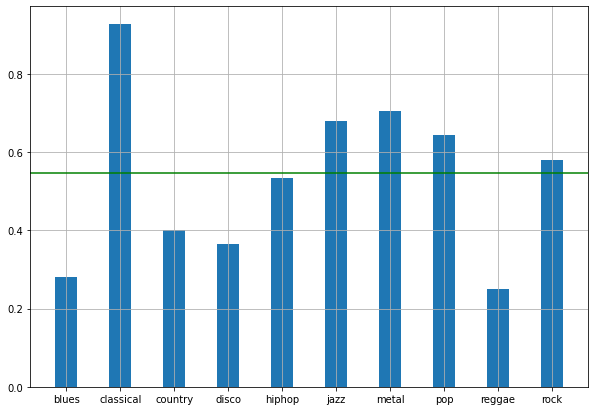

In [10]:
hist_dict = {}
for i in range(0, 10):
    cur_label = np.zeros(10)
    cur_label[i] = 1
    labels_i = np.where((test_labels == cur_label).all(axis=1) == True)[0]
    inputs_test = np.array([d for i, d in enumerate(test_input) if i in labels_i])
    labels_test = np.zeros(shape=(len(labels_i), 10))
    for j in range(0, len(labels_i)): labels_test[j] = cur_label
    _, acc = model.evaluate(inputs_test, labels_test)
    hist_dict.update({genres[i] : acc})
_, avg_acc = model.evaluate(test_input, test_labels)
print(f"avg accuracy: {avg_acc}")
print(hist_dict)
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)
ax.grid(True)
ax.bar(hist_dict.keys(), hist_dict.values(), width=0.4)
ax.axhline(avg_acc, color='g')
plt.show()